In [2]:
import anndata
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')

/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
#normalizaiton

gene_expression_data = adata.layers['logcounts']

from sklearn.preprocessing import MinMaxScaler

# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)


number_samples = adata.shape[0]
number_genes = adata.shape[1]

input_dim = number_genes

encoding_dim = 100 

In [4]:
from keras import layers, models
from keras.callbacks import EarlyStopping

# Define a deeper and more sophisticated autoencoder
input_layer = layers.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(256, activation=None)(input_layer)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.3)(encoded)

encoded = layers.Dense(128, activation=None)(encoded)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.3)(encoded)

encoded = layers.Dense(64, activation=None)(encoded)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)

encoded = layers.Dense(encoding_dim, activation=None)(encoded)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)

# Decoder
decoded = layers.Dense(64, activation=None)(encoded)
decoded = layers.LeakyReLU()(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(128, activation=None)(decoded)
decoded = layers.LeakyReLU()(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(256, activation=None)(decoded)
decoded = layers.LeakyReLU()(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder Model
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
encoder = models.Model(inputs=input_layer, outputs=encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(gene_expression_data, gene_expression_data,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])

# Get the low-dimensional representation
low_dimensional_representation = encoder.predict(gene_expression_data)

Epoch 1/100
12/12 [==============================] - 2s 76ms/step - loss: 0.0564 - val_loss: 0.0148
Epoch 2/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0125 - val_loss: 0.0148
Epoch 3/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0109 - val_loss: 0.0148
Epoch 4/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0101 - val_loss: 0.0148
Epoch 5/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0097 - val_loss: 0.0148
Epoch 6/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0083 - val_loss: 0.0147
Epoch 7/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0083 - val_loss: 0.0144
Epoch 8/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0091 - val_loss: 0.0139
Epoch 9/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0098 - val_loss: 0.0132
Epoch 10/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0082 - val_loss: 0.0122

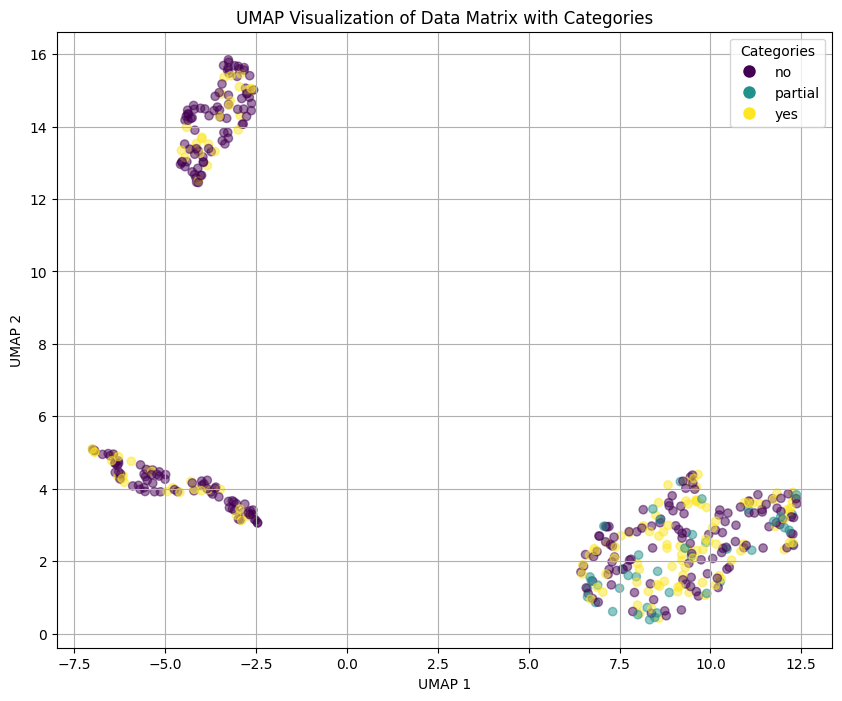

In [10]:
categories =  adata.obs['Response']
# categories =  adata.obs['Platform']

# Step 3: Run UMAP
umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use
umap_result = umap_model.fit_transform(low_dimensional_representation)

# Step 4: Create a scatter plot with labels
plt.figure(figsize=(10, 8))

# Define a colormap
unique_categories = np.unique(categories)
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_categories))))

# Create a scatter plot with color coding based on categories
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], 
                      c=pd.Categorical(categories).codes, alpha=0.5, cmap=cmap)

# Add a title and labels
plt.title('UMAP Visualization of Data Matrix with Categories')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create a legend
# Create a legend with unique categories
handles = []
for i, cat in enumerate(unique_categories):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=cat,
                                markerfacecolor=cmap(i), markersize=10))

# Add legend to the plot
plt.legend(handles=handles, title="Categories")

plt.grid()
plt.show()

In [9]:
adata.obs

,Response,TRG,therapy,Treatment,Platform,batch
GSM3899156_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
GSM3899157_GSE133057,partial,3,CRT,pre,GPL6102,GSE133057
GSM3899158_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
GSM3899159_GSE133057,partial,3,CRT,pre,GPL6102,GSE133057
GSM3899160_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
...,...,...,...,...,...,...
GSM6390458_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390459_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390460_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390461_GSE209746,yes,unknown,CRT,pre,GPL16791,GSE209746
